## ABOUBAKAR Ouattara


# TP1 - Modèle Binomial pour Options Européennes

Dans ce travail pratique, nous allons implémenter le modèle binomial pour les options européennes de type call. Nous allons répondre aux différentes questions demandées dans le TP en fournissant les formules mathématiques et les implémentations Python pour chaque question.
Enfin nous allons tirer une conclusion sur le modèle binomial et le prix donné par la formule fermée de Black Shole


## QUESTION 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Valeurs numerique à utiliser

sigma = 0.3
r = 0.05
mu = 0.1
S0 = 100
n = 50
T = 2


## Question (a) : Fonction `Sn`

La fonction `Sn` calcule le vecteur des prix possibles de l'actif sous-jacent à la période \( j \) dans un modèle binomial.

### Formules :

Les coefficients d'évolution du sous-jacent sont définis comme :

$u_n = e^{\mu h_n + \sigma \sqrt{h_n}}$   and     $ d_n = e^{\mu h_n - \sigma \sqrt{h_n}}$



Le prix possible à la période $j$ est calculé comme :
$$
S_n^j(i) = S_0 \cdot u_n^{j-i} \cdot d_n^i, \quad 0 \leq i \leq j
$$


In [3]:
#Question a

def Sn(T, n, mu, sigma, j, S0=100):
    # par defaut S0 prend 1
    hn = T/n
    Un = np.exp(mu*hn + sigma*np.sqrt(hn))
    dn = np.exp(mu*hn - sigma*np.sqrt(hn))

    Snj = [S0*(Un**(j-i))*(dn**i) for i in range(j+1)] # creation des prix possibles à la date j dans une liste

    return np.array(Snj)

j = 20
print("Valeurs de Sn pour J=20")
print( Sn(T, n, mu, sigma, j, S0=100))


Valeurs de Sn pour J=20
[359.66397256 318.99332761 282.92170144 250.92903899 222.55409285
 197.38777322 175.06725003 155.27072185 137.71277643 122.14027582
 108.32870677  96.07894392  85.2143789   75.57837415  67.0320046
  59.4520548   52.7292424   46.7666427   41.47829117  36.78794412
  32.62797946]


## Question (b) : Fonction `Payoff`

La fonction `Payoff` calcule le payoff d'une option européenne de type call à la maturité.

Le payoff est donc donné par :
$$
\text{Payoff}(S_T, K) = \max(S_T - K, 0)
$$


In [4]:
#Question b

# je vais utiliser le vecteur des prix possible à la date T càd j = n pour ecrre cette fonction
def Payoff(T, n, mu, sigma, K, S0=100):
    #Calcul des prix possible à maturité
    ST = Sn(T, n, mu, sigma, n, S0)

    payoff = np.maximum(ST - K, 0) # contient les vecteurs de payoff a maturité

    return payoff
K=80
print("valeurs du Payoff à T=2 pour K=80")
print( Payoff(T, n, mu, sigma, K, S0))

valeurs du Payoff à T=2 pour K=80
[2373.25301971 2095.84023962 1849.79717555 1631.57655371 1438.0322245
 1266.3738035  1114.12644178  979.09514524  859.33312874  753.11374877
  658.90560989  575.35048622  501.24373944  435.51695122  377.22251951
  325.51999668  279.66397256  238.99332761  202.92170144  170.92903899
  142.55409285  117.38777322   95.06725003   75.27072185   57.71277643
   42.14027582   28.32870677   16.07894392    5.2143789     0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]


## Question (c) : Fonction `Calln`

Pour implementer la fonction `Calln`, nous allons utiliser  la rétro-propagation pour avoir le prix de l'option à la date 0.

Pour cela nous avons besoin de la probabiblité risque-neutre:
$$
p = \frac{e^{r h_n} - d_n}{u_n - d_n}
$$


Puis, nous utilisons cette probabilité pour remonter jusqu'à la période $t = 0 $  via l'actualisation au taux sans risque avec la formule suivante:

$$
V_j = e^{-r h_n} \left( p V_{j+1}^{\text{up}} + (1 - p) V_{j+1}^{\text{down}} \right)
$$



In [5]:
#Question c 

# le mieux dans cette situation est d'ultiliser la retro-Propagation, elle permet de calculer la valeur de l'optionn  à chaque periode
def Calln(T, n, r, mu, sigma, K, S0=100):

    hn = T/n
    Un = np.exp(mu*hn + sigma*np.sqrt(hn))
    dn = np.exp(mu*hn - sigma*np.sqrt(hn))

    # calculons la probabilité risuqe neutre qui nous permettra d'actualiser le prix a chaque periode

    p = (np.exp(r*hn) - dn)/(Un-dn)

    # payoff à maturité
    payoff = Payoff(T, n, mu, sigma, K, S0)

    for j in range(n-1, -1, -1):
        payoff = np.exp(-r * hn) * (p * payoff[:-1] + (1 - p) * payoff[1:])
    return payoff[0]

print("Prix du Call à t=0 pour K=80 est:", Calln(T, n, r, mu, sigma, K, S0))

Prix du Call à t=0 pour K=80 est: 32.216469329905834


## Question (d) : Fonction `Deltan`

La fonction `Deltan` calcule la stratégie de couverture $\Delta_n^j $.

Cette strategie est donnée par la formule:
$$
\Delta_n^j = \frac{V_{j+1}^{\text{up}} - V_{j+1}^{\text{down}}}{S_j^{\text{up}} - S_j^{\text{down}}}
$$


In [6]:

# Question d


def deltan(T, n, r, mu, sigma, K, j, S0=100):
    # dans cette questions je vais reprendre la retro-propagation, mais cette fois jusqu'à m'arreter en j

    hn = T/n
    Un = np.exp(mu*hn + sigma*np.sqrt(hn))
    dn = np.exp(mu*hn - sigma*np.sqrt(hn))

    p = (np.exp(r*hn) - dn)/(Un-dn)

    Sj = Sn(T, n, mu, sigma, j, S0) # les prix possibles de l'option en j

    payoff = Payoff(T, n, mu, sigma, K, S0)

    # Retro-propagation jusqu'a j
    for m in range(n-1, j-1, -1):
        payoff = np.exp(-r * hn) * (p * payoff[:-1] + (1 - p) * payoff[1:])
        
    # Calcul de la stratégie de couverture
    Deltan_j = [(payoff[i + 1] - payoff[i]) / (Sj[i + 1] - Sj[i]) for i in range(j)]

    return np.array(Deltan_j)
print("strategie en J=20 et K=80", deltan(T, n, r, mu, sigma, K, j, S0))

strategie en J=20 et K=80 [0.99999977 0.99999765 0.99998282 0.99990284 0.99955654 0.99832088
 0.99461737 0.98516196 0.96438085 0.92474874 0.85876546 0.76243396
 0.63871867 0.49867028 0.35878826 0.23551331 0.13975247 0.07431562
 0.03510484 0.0145933 ]


## Question (e) : Étude de la dépendance de K

Nous allons étudier la dépendance du prix d'exercice \( K \) sur les résultats des fonctions `Calln` et `Deltan`.


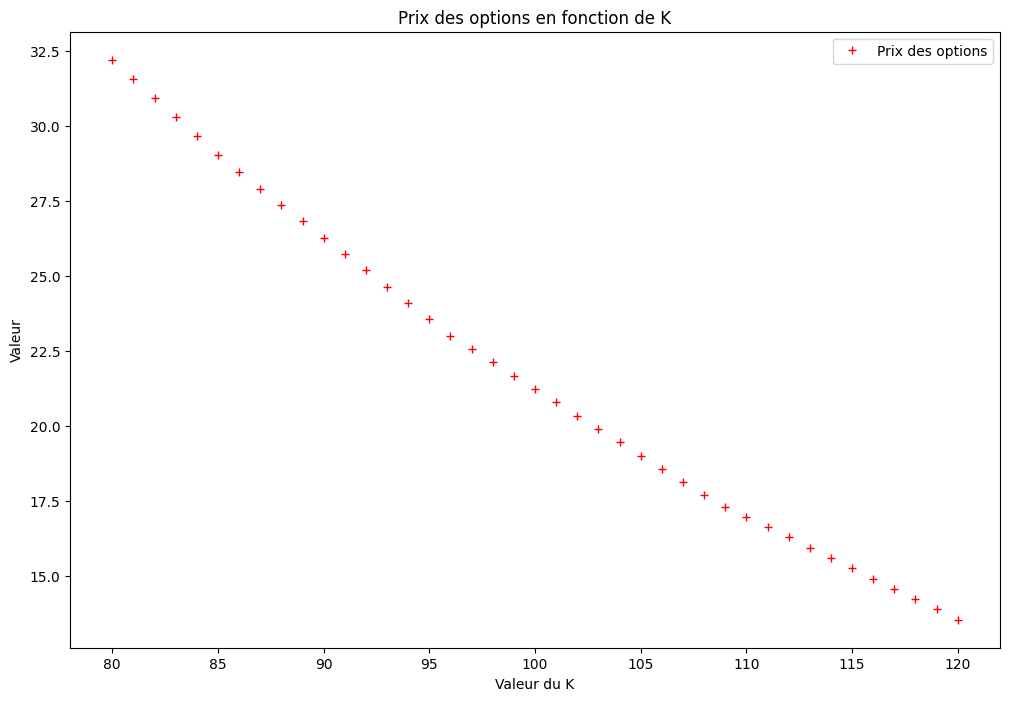

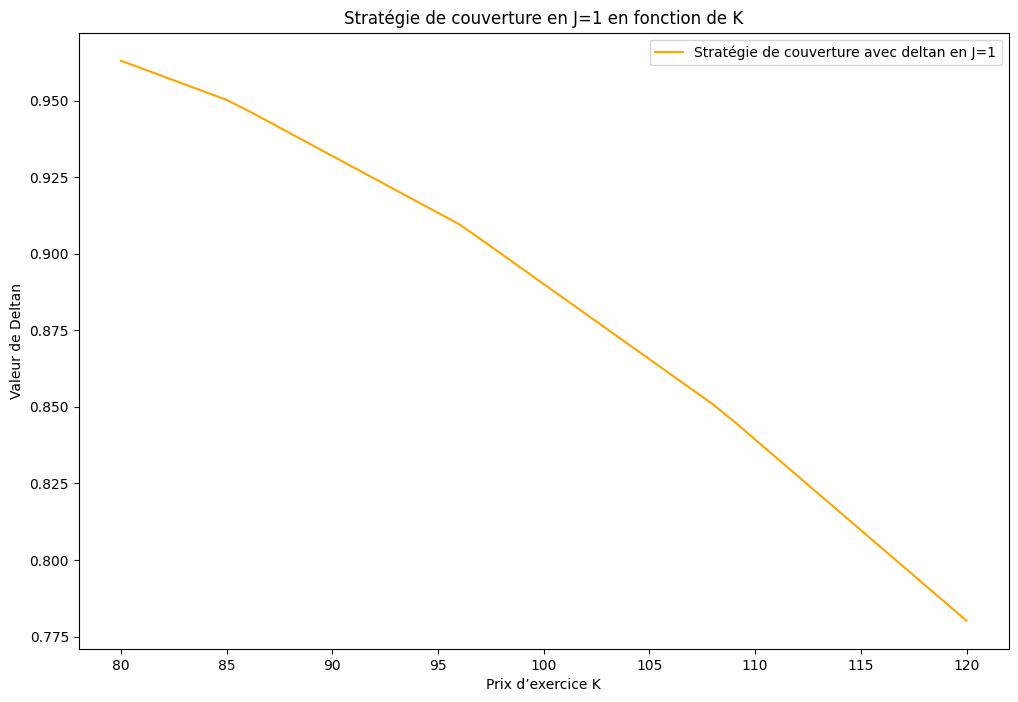

In [12]:
# Question e

# Dans cette question, je vais essayer de tracer la courbe des prix de l'option et du Deltan en  fonction de differents valeur du strik

K  = np.arange(80, 121, 1)

Calln_values  = np.array([Calln(T, n, r, mu, sigma, k, S0) for k in K])

Deltan_values  = np.array([deltan(T, n, r, mu, sigma, k, 6, S0)[0] for k in K])

# graphique pour les prix des options (Calln
plt.figure(figsize=(12, 8))
plt.plot(K, Calln_values, '+' , c='red', label='Prix des options')
plt.xlabel('Valeur du K')  
plt.ylabel('Valeur')        
plt.title('Prix des options en fonction de K') 
plt.legend()
plt.show()


# graphique pour la stratégie de couverture Deltan
plt.figure(figsize=(12, 8))
plt.plot(K, Deltan_values, label='Stratégie de couverture avec deltan en J=1', color='orange', linestyle='solid')
plt.xlabel('Prix d’exercice K')
plt.ylabel('Valeur de Deltan')
plt.title('Stratégie de couverture en J=1 en fonction de K')
plt.legend()
plt.show()


On remarque donc une decroissance de la strategie, quelque soit la valeur de j et aussi du prix call en fonction du strick. Cela est tout à fait normal, plus le strick est élévé, plus l'option est susceptible de ne pas être exercé. De ce fait mieux vaut detenir moin d'actif pour minimiser la perte.

## QUESTION 2

## Question (a)


La Formule de Black Sholes nous donne le prix d'un Call à $t=0$ par la formule
$$
\text{Call} = S_0 N(d_1) - N(d_2) K e^{-rT}
$$
$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left( r + \frac{\sigma^2}{2} \right)T}{\sigma \sqrt{T}}$

$d_2 = d_1 - \sigma \sqrt{T}$

Ou $ N(x) $ est la fonction de repartition de la normale centré reduite


In [8]:
#Question a

def Call(T, r, sigma, K, S0=100):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 =  d2 = d1 - sigma * np.sqrt(T)
    return S0 * N(d1) - K * np.exp(-r*T)* N(d2)
    
K = 80
print("prix Black Shole:", Call(T, r, sigma, K, S0))


prix Black Shole: 32.19291006531836


## Question (b)

In [9]:
#Question b

def error(T, n, r, mu, sigma, K, S0=100):
    
    calln_val = Calln(T, n, r, mu, sigma, K, S0)
    call_BS = Call(T, r, sigma, K, S0)

    return (calln_val/call_BS) -1


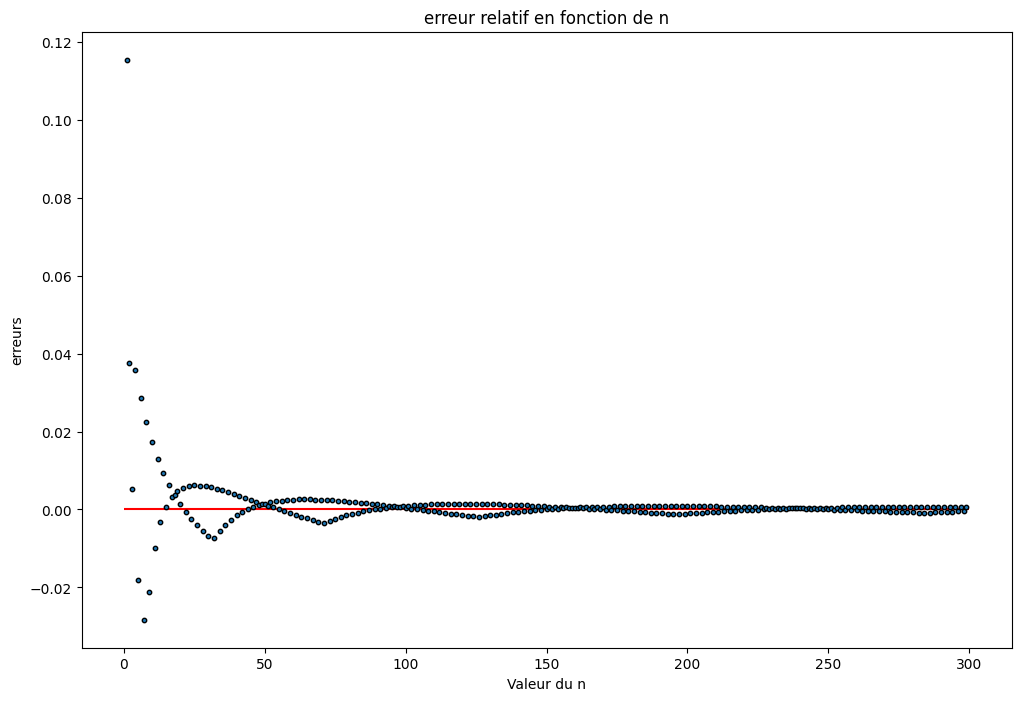

In [10]:
#Traçons cette erreur
K = 105 # strick
Max=300
N = np.arange(1, Max)
errors =  np.array([error(T, n, r, mu, sigma, K, S0) for n in N])

plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(N, errors,edgecolors='k', s=10)
plt.hlines(0, 0, Max, 'r', zorder=-1)
plt.xlabel('Valeur du n')  
plt.ylabel('erreurs')        
plt.title('erreur relatif en fonction de n') 
plt.show()


L'erreur relatif nous permet de comprendre que le prix calculer à partir du modéle binomial converge très rapidement vers le prix Black Shole en fonction du nombre de periode.